In [1]:
%reset -f

In [2]:
import tensorflow as tf
import gc
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

from models import build_autoencoder
from sklearn.model_selection import train_test_split

In [3]:
gc.collect()

21

In [4]:
print("Number of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

strategy = tf.distribute.MirroredStrategy()

Number of GPUs Available:  1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [5]:
np.random.seed(42)
tf.random.set_seed(42)

# if crop is not used
# IMAGE_HEIGHT = 4096//4
# IMAGE_WIDTH = 3328//4

# if crop is used
IMAGE_HEIGHT = 3200//2
IMAGE_WIDTH = 1728//2

image_size = (IMAGE_HEIGHT, IMAGE_WIDTH)

input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 1)

In [6]:
image_dir = r"D:\FYP\project\data\raw\abnormal\images"

image_files = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir)])[:-2]

image_files_unseen = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir)])[-2:]

In [7]:
# Preprocessing functions

def dilate(img, kernel_size, iterations):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilation = cv2.dilate(img, kernel, iterations=iterations)
    return dilation


def crop_breast(img):
    _, thresh = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped_image = img[y:y+h, x:x+w]
    new_height, new_width = cropped_image.shape[:2]
    return cropped_image, int(new_height), int(new_width)


def clahe(img, clip, gridSize):
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(gridSize, gridSize))
    enhanced_image = clahe.apply(img)
    return enhanced_image


def normalize_min_max(img):
    min_val = np.min(img)
    max_val = np.max(img)
    normalized = (img - min_val) / (max_val - min_val)
    return normalized.astype(np.float32)


def preprocessing_pipeline(img):
    image = dilate(img.numpy().squeeze(), kernel_size=3, iterations=1)
    image, new_height, new_width = crop_breast(image)
    image = clahe(image, 1.0, 20)
    image = image.reshape(new_height, new_width, 1)
    img_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    return img_tensor, # add comma to return value into a tuple, otherwise, only one item - will return as a list 


def wrap_autoencoder_preprocessing(image):
    
    # processed_image = tf.py_function(preprocessing_pipeline, [image], [tf.float32])
    processed_image = tf.py_function(preprocessing_pipeline, [image], [tf.float32])[0]
    
    processed_image.set_shape([None, None, 1])
    
    return processed_image


In [8]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=1)
    img = wrap_autoencoder_preprocessing(img)
    img = tf.image.resize(img, image_size)
    img = img / 255.0
    return img, img

In [9]:
# select only a random set of images
selected_images = random.sample(image_files, 50)

train_images, test_images, _, _ = train_test_split(selected_images, 
                                                 np.zeros(len(selected_images)), 
                                                 test_size=0.2, 
                                                 random_state=42)

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images))

batch_size = 5
prefetch_buffer_size=tf.data.AUTOTUNE

train_dataset = train_dataset.map(load_image).batch(batch_size).prefetch(prefetch_buffer_size).cache(filename='cached_train_data.tfrecord')
test_dataset = test_dataset.map(load_image).batch(batch_size).prefetch(prefetch_buffer_size).cache(filename='cached_test_data.tfrecord')

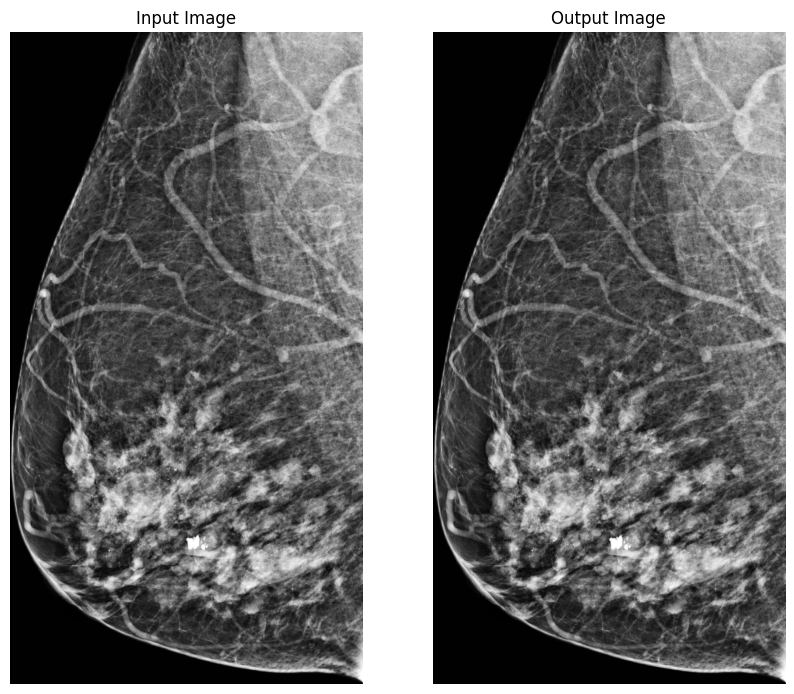

In [11]:
def show_img_mask(dataset, batch, image_number):
    for input_imgs, output_imgs in dataset.take(batch):
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(tf.squeeze(input_imgs[image_number]), cmap='gray')
        plt.title('Input Image')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(tf.squeeze(output_imgs[image_number]), cmap='gray')
        plt.title('Output Image')
        plt.axis('off')
        plt.show()
        
show_img_mask(train_dataset, 1, 0)

In [12]:
gc.collect()

3948

In [13]:
from skimage.metrics import structural_similarity as ssim

# Structural Similarity Index (SSIM)
# metric is used for measuring the similarity between two images.
# considers changes in texture, luminance, and contrast

def ssim_metric(y_true, y_pred):
    y_true = float(y_true)
    y_pred = float(y_pred)
    ssim_value = tf.image.ssim(y_true, y_pred, max_val=1.0)
    return ssim_value

# Peak Signal-to-Noise Ratio (PSNR)
    
def psnr_metric(y_true, y_pred):
    y_true = float(y_true)
    y_pred = float(y_pred)
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

In [14]:
def get_model(input_shape):
    model = build_autoencoder(input_shape, num_filters=16)
    return model

In [15]:
from tensorflow.keras.optimizers import Adam

with strategy.scope():
    model = get_model(input_shape)
        
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error', psnr_metric, ssim_metric])
        
    print(model.summary())

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [16]:
epochs = 30

history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=test_dataset,
                    verbose=1, 
                    shuffle=True
                )

Epoch 1/30


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[5,64,400,216] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Autoencoder/dropout_6/dropout/Mul (defined at \threading.py:926) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[div_no_nan_1/ReadVariableOp_1/_224]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[5,64,400,216] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Autoencoder/dropout_6/dropout/Mul (defined at \threading.py:926) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_10007]

Function call stack:
train_function -> train_function


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot the training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
axs[0].plot(epochs, loss, 'y', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot the training and validation accuracy
abs_error = history.history['mean_absolute_error']
val_abs_error = history.history['val_mean_absolute_error']
axs[1].plot(epochs, abs_error, 'y', label='Training mean_absolute_error')
axs[1].plot(epochs, val_abs_error, 'r', label='Validation mean_absolute_error')
axs[1].set_title('Training and validation mean_absolute_error')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('mean_absolute_error')
axs[1].legend()

plt.show()

In [ ]:
def check_predictions(dataset, batch, img):
    for input_images, output_images in dataset.take(batch):
        
        predicted_images = model.predict(input_images)
    
        plt.figure(figsize=(10, 10))
        
        plt.subplot(1, 2, 1)
        plt.imshow(output_images[img], cmap='gray')
        plt.title('Expected Output')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(predicted_images[img], cmap='gray')
        plt.title('Output')
        plt.axis('off')

        plt.show()
        
check_predictions(dataset=test_dataset, batch=1, img=0)

In [ ]:
def predict_single_image(model, image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=1)
    image = preprocessing_pipeline(image)
    image = tf.image.resize(image, image_size)
    image = image / 255
    
    # image = tf.expand_dims(image, axis=0)
    
    predicted_image = model.predict(image)

    
    plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.imshow(image[0], cmap='gray')
    plt.title("Original Image")
    
    plt.subplot(122)
    plt.imshow(predicted_image[0], cmap='gray')
    plt.title("Predicted Image")
    
    plt.show()
    

unseen_image = 'data/abnormal/0034-LMLO.png'
predict_single_image(model, unseen_image)

In [ ]:
unseen_image2 = image_files_unseen[0]
predict_single_image(model, unseen_image2)

https://medium.com/game-of-bits/what-are-autoencoders-in-deep-learning-ba802298bc70

https://en.wikipedia.org/wiki/Autoencoder#Information_Retrieval

https://en.wikipedia.org/wiki/Super-resolution_imaging